In [1]:
import pandas as pd
import numpy as np

## Users

In [2]:
users  = pd.read_csv('./clean/accounts.csv', on_bad_lines='skip', low_memory=False, lineterminator='\n') #We are encoutering some bad lines creating some error so we skip over them
cat=["Id","Gender", "Social network"]
num=['Country id','City id','Followers',"Engagement","Posts","Estimated reach","Avg. views per video", "Avg. comments per post", "Avg. likes per post", "Avg. posts per week"]
n = 20000
clean_df = users[cat+num][:n]
clean_df = clean_df.rename(columns={'City id': 'City','Country id':'Country'})
for i in clean_df.columns:
    clean_df = clean_df.rename(columns={i: i.replace(" ","_")})

In [3]:
#City-ID mapping
city_ids = pd.read_csv('../SocialTalk 2023/cities.csv', low_memory=False) 
city_ids['Name'] = city_ids['Name'].str.replace(" ","")#Replace white space by "_"

clean_df['City'] = clean_df['City'].map(city_ids.set_index('Id')['Name'].to_dict())

In [4]:
#Country-ID mapping
country_ids = pd.read_csv('../SocialTalk 2023/countries.csv', low_memory=False)
country_ids['Name'] = country_ids['Name'].str.replace(" ","")#Replace white space by "_"

clean_df['Country'] = clean_df['Country'].map(country_ids.set_index('Id')['Name'].to_dict())

In [5]:
# Removing outlier
clean_df.loc[clean_df['Posts'] == 0,'Posts'] = np.nan 
clean_df.loc[clean_df['Avg._views_per_video'] == 0,'Avg._views_per_video'] = np.nan

## Audience

In [6]:
audience_genders = pd.read_csv('./clean/accounts-audience-genders.csv')[:n]
for i in audience_genders.columns[1:]:
    audience_genders.rename(columns = {i:'Audience-Gender-' + i.replace(' ','_')}, inplace = True)

In [7]:
audience_ages = pd.read_csv('./clean/accounts-audience-ages.csv')
audience_ages = audience_ages[:n]
for i in audience_ages.columns:
    if(i != 'Account Id'):
        audience_ages.rename(columns = {i:'Audience-Age-' + i.replace(' ','_')}, inplace = True)

In [8]:
def get_real_audience_data(df,audience_data):

    #merging audience gender distribution and accounts data
    print("Merging")
    df = df.merge(audience_data,how='left' ,left_on='Id',right_on = 'Account Id')
    df.drop(['Account Id'], axis=1,inplace=True)
    
    for audience_data_column in audience_data.columns:
        if(audience_data_column != 'Account Id'):
            print('Turning '+ audience_data_column + ' into raw numbers')
            df[audience_data_column] = df[audience_data_column] * df['Followers'] # Turning into raw numbers
            print('Binning')
            df[audience_data_column] = pd.qcut(df[audience_data_column], q=[0, .25, .75, 1], labels=['Low', 'Medium', 'High']) #binning 
    return df

In [9]:
clean_df = get_real_audience_data(clean_df,audience_genders)

Merging
Turning Audience-Gender-MALE_% into raw numbers
Binning
Turning Audience-Gender-FEMALE_% into raw numbers
Binning


In [10]:
clean_df = get_real_audience_data(clean_df,audience_ages)

Merging
Turning Audience-Age-13-17_% into raw numbers
Binning
Turning Audience-Age-18-24_% into raw numbers
Binning
Turning Audience-Age-25-34_% into raw numbers
Binning
Turning Audience-Age-35-44_% into raw numbers
Binning
Turning Audience-Age-45-64_% into raw numbers
Binning
Turning Audience-Age-65-_% into raw numbers
Binning


## Interests and Brands

In [11]:
brand_ids = pd.read_csv('../SocialTalk 2023/brands.csv', low_memory=False) # Shape (3792, 2)
account_brands = pd.read_csv('../SocialTalk 2023/accounts-brands.csv', low_memory=False)
interest_ids = pd.read_csv('../SocialTalk 2023/interests.csv', low_memory=False) # Shape (60, 2)
account_interests = pd.read_csv('../SocialTalk 2023/accounts-interests.csv', low_memory=False)

In [12]:
brand_ids['Name'] = brand_ids['Name'].str.replace(" ","_")
interest_ids['Name'] = interest_ids['Name'].str.replace(" ","_")

In [13]:
brand_ids['label'] = 'Brand:' + brand_ids['Name'].astype(str)
account_brands['Account Id'] = 'Account:' + account_brands['Account Id'].astype(str)
account_brands['Brand Id'] = account_brands['Brand Id'].map(brand_ids.set_index('Id')['label'].to_dict())
interest_ids['label'] = 'Interest:' + interest_ids['Name'].astype(str)
account_interests['Account Id'] = 'Account:' + account_interests['Account Id'].astype(str)
account_interests['Interest Id'] = account_interests['Interest Id'].map(interest_ids.set_index('Id')['label'].to_dict())

In [14]:
account_brands = account_brands[:n]
account_interests = account_interests[:n]

## Audience fully enriched data (less records)

In [40]:
audience_brands = pd.read_csv('../SocialTalk 2023/accounts-audience-brands.csv')
audience_cities = pd.read_csv('../SocialTalk 2023/accounts-audience-cities.csv')
audience_countries = pd.read_csv('../SocialTalk 2023/accounts-audience-countries.csv')
audience_interests = pd.read_csv('../SocialTalk 2023/accounts-audience-interests.csv')

In [41]:
# Down sampling audience_countries and audience_interests
sample_accounts = clean_df["Id"]
audience_countries = audience_countries[audience_countries['Account Id'].isin(sample_accounts)]
audience_interests = audience_interests[audience_interests['Account Id'].isin(sample_accounts)]
audience_brands = audience_brands[audience_brands['Account Id'].isin(sample_accounts)]
audience_cities = audience_cities[audience_cities['Account Id'].isin(sample_accounts)]

In [42]:
# Mapping name and Ids
audience_brands['Brand Id'] = audience_brands['Brand Id'].map(brand_ids.set_index('Id')['Name'].to_dict())
audience_cities['City Id'] = audience_cities['City Id'].map(city_ids.set_index('Id')['Name'].to_dict())
audience_countries['Country Id'] = audience_countries['Country Id'].map(country_ids.set_index('Id')['Name'].to_dict())
audience_interests['Interest Id'] = audience_interests['Interest Id'].map(interest_ids.set_index('Id')['Name'].to_dict())

In [43]:
#Binning on quartile
audience_brands['%'] = pd.qcut(audience_brands['%'], q=[0, .25, .75, 1], labels=['Low', 'Medium', 'High'])
audience_cities['%'] = pd.qcut(audience_cities['%'], q=[0, .25, .75, 1], labels=['Low', 'Medium', 'High'])
audience_countries['%'] = pd.qcut(audience_countries['%'], q=[0, .25, .75, 1], labels=['Low', 'Medium', 'High'])
audience_interests['%'] = pd.qcut(audience_interests['%'], q=[0, .25, .75, 1], labels=['Low', 'Medium', 'High'])

## Archetype

### positive: followers:High and Audience-Age-18-24:High

In [49]:
# positive: followers:High and Audience-Age-18-24:High
names = ["Martita de Graná", "Ken Appledorn", "er_christian_", "tamara_gorro", "Jordan Schmidt"]
Ids = users[:n].loc[users["Name"].isin(names)]["Id"].values

In [50]:
sample = clean_df[clean_df["Id"].isin(Ids)]#[["Followers","Audience-Age-18-24_%"]].value_counts()

In [51]:
sample.describe(include = ['object','category'])
#sample.dtypes

,Gender,Social_network,Country,City,Audience-Gender-MALE_%,Audience-Gender-FEMALE_%,Audience-Age-13-17_%,Audience-Age-18-24_%,Audience-Age-25-34_%,Audience-Age-35-44_%,Audience-Age-45-64_%,Audience-Age-65-_%
count,5,5,5,0,5,5,5,5,5,5,5,5
unique,2,1,2,0,1,1,1,1,1,2,2,3
top,Male,TikTok,Spain,NaN,High,High,High,High,High,High,High,Low
freq,3,5,4,NaN,5,5,5,5,5,4,4,2


In [52]:
#getiing audience Interests
s = audience_interests[audience_interests["Account Id"].isin(Ids)]
s.describe(include = ['object','category'])

,Interest Id,%
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [53]:
#getting audience brands
s = audience_brands[audience_brands["Account Id"].isin(Ids)]
s.describe(include = ['object','category'])

,Brand Id,%
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


### positive: Audience-Interest:Gaming and Avg_views_per_video:High

In [54]:
# positive: Audience-Interest:Gaming and Avg_views_per_video:High
names = ["JaviGeek", "mr_ziuk", "Josefina Marcos", "Blake Richardson", "DOMINIQUE"]
Ids = users[:n].loc[users["Name"].isin(names)]["Id"].values

In [55]:
sample = clean_df[clean_df["Id"].isin(Ids)]#[["Followers","Audience-Age-18-24_%"]].value_counts()
sample.describe(include = ['object','category'])

,Gender,Social_network,Country,City,Audience-Gender-MALE_%,Audience-Gender-FEMALE_%,Audience-Age-13-17_%,Audience-Age-18-24_%,Audience-Age-25-34_%,Audience-Age-35-44_%,Audience-Age-45-64_%,Audience-Age-65-_%
count,4,4,4,2,2,2,2,2,2,2,2,2
unique,3,1,2,2,1,2,1,1,1,2,2,2
top,Male,Instagram,Spain,Madrid,High,Medium,High,High,High,Medium,Medium,Medium
freq,2,4,2,1,2,1,2,2,2,1,1,1


<AxesSubplot:>

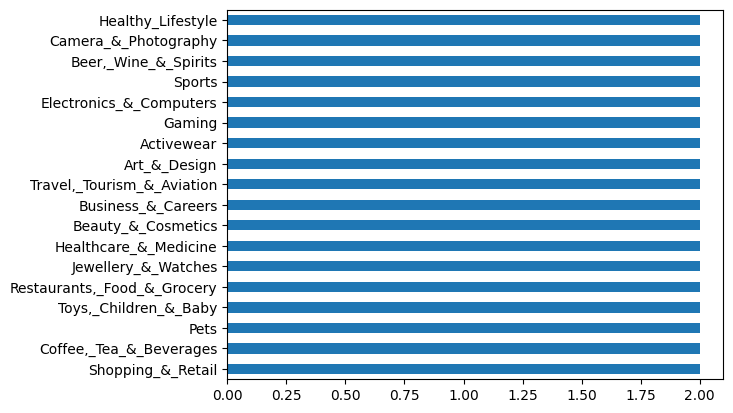

In [62]:
#getting interests data
s = audience_interests[audience_interests["Account Id"].isin(Ids)]
s.describe(include = ['object','category'])
s["Interest Id"].value_counts()[:].plot(kind='barh')

In [63]:
#getting brand data
s = audience_brands[audience_brands["Account Id"].isin(Ids)]
s

,Account Id,Brand Id,%


### positive: Audience_gender-Male:High and Audience-Interest:Beauty&Cosmetics

In [64]:
# positive: Audience_gender-Male:High and Audience-Interest:Beauty&Cosmetics
names = ["Mike Thalassitis", "francesca allen", "♡ Dani Dyer ♡", "Kate Ferdinand", "#BLACKLIVESMATTER"]
Ids = users[:n].loc[users["Name"].isin(names)]["Id"].values

In [66]:
sample = clean_df[clean_df["Id"].isin(Ids)]#[["Followers","Audience-Age-18-24_%"]].value_counts()
sample.describe(include = ['object','category'])
#sample.dtypes

,Gender,Social_network,Country,City,Audience-Gender-MALE_%,Audience-Gender-FEMALE_%,Audience-Age-13-17_%,Audience-Age-18-24_%,Audience-Age-25-34_%,Audience-Age-35-44_%,Audience-Age-45-64_%,Audience-Age-65-_%
count,5,5,5,0,5,5,5,5,5,5,5,5
unique,2,1,1,0,1,1,1,1,1,1,1,2
top,Female,Instagram,UnitedKingdom,NaN,High,High,High,High,High,High,High,High
freq,3,5,5,NaN,5,5,5,5,5,5,5,4


<AxesSubplot:>

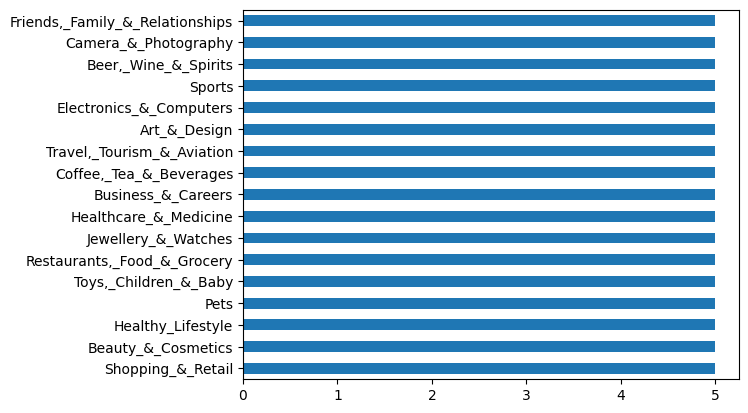

In [67]:
#getting interests data
s = audience_interests[audience_interests["Account Id"].isin(Ids)]
s.describe(include = ['object','category'])
s["Interest Id"].value_counts()[:].plot(kind='barh')

In [68]:
#getting brand data
s = audience_brands[audience_brands["Account Id"].isin(Ids)]
s

,Account Id,Brand Id,%


### positive: Audience_brand_BBC:High and Avg_post_per_week:High

In [70]:
# positive: Audience_brand_BBC:High and Avg_post_per_week:High
names = ["July Jones", "𝘾𝙍𝟳 𝙁𝘼𝙉 𝙋𝘼𝙂𝙀", "Toys Men", "Boy Kortekaas", "GiantPixel Photography"]
Ids = users[:n].loc[users["Name"].isin(names)]["Id"].values

In [71]:
sample = clean_df[clean_df["Id"].isin(Ids)]#[["Followers","Audience-Age-18-24_%"]].value_counts()
sample.describe(include = ['object','category'])
#sample.dtypes

,Gender,Social_network,Country,City,Audience-Gender-MALE_%,Audience-Gender-FEMALE_%,Audience-Age-13-17_%,Audience-Age-18-24_%,Audience-Age-25-34_%,Audience-Age-35-44_%,Audience-Age-45-64_%,Audience-Age-65-_%
count,0,5,4,0,1,1,1,1,1,1,1,1
unique,0,1,2,0,1,1,1,1,1,1,1,1
top,NaN,Instagram,Spain,NaN,High,High,High,High,High,High,High,Medium
freq,NaN,5,3,NaN,1,1,1,1,1,1,1,1


<AxesSubplot:>

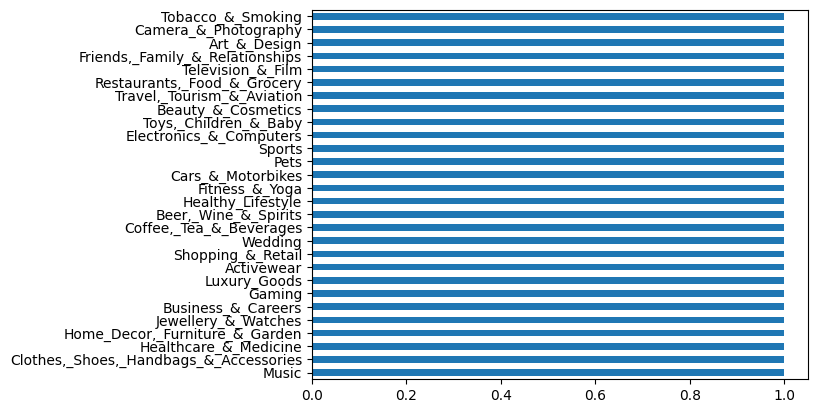

In [72]:
#getting interests data
s = audience_interests[audience_interests["Account Id"].isin(Ids)]
s.describe(include = ['object','category'])
s["Interest Id"].value_counts()[:].plot(kind='barh')

<AxesSubplot:>

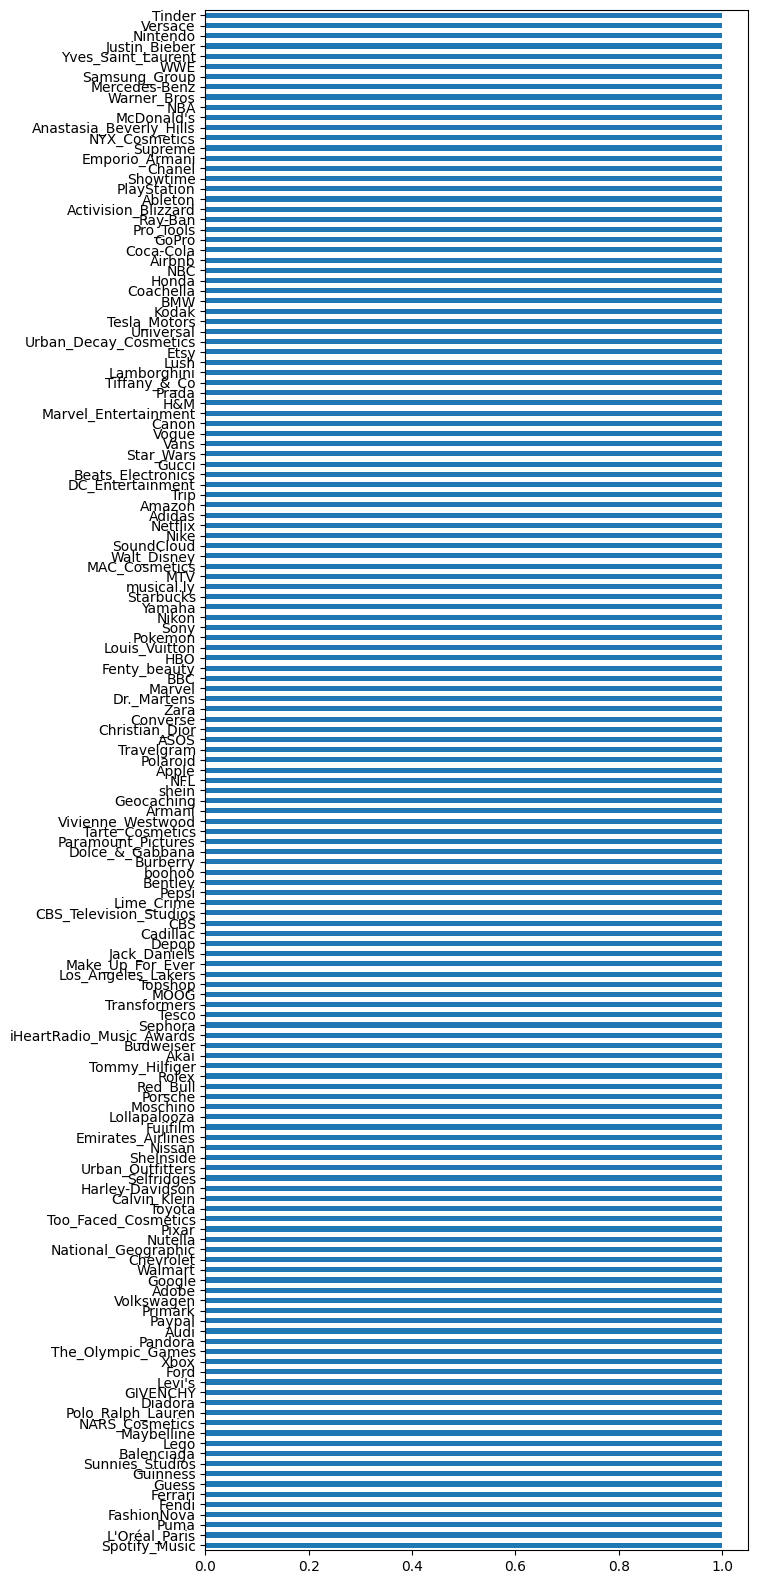

In [80]:
#getting brand data
s = audience_brands[audience_brands["Account Id"].isin(Ids)]
s["Brand Id"].value_counts()[:].plot(kind='barh',figsize=(7,20))